# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [46]:
import os

practice_dir_path = r'C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics'
os.chdir(practice_dir_path)

print("Текущая директория:", os.getcwd())

Текущая директория: C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics


Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [14]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [39]:
%pip install sktime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt

# Убрали проблемный импорт: from google.colab.patches import cv2_imshow

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.classification import TimeSeriesKNN, calculate_accuracy
#from modules.image_converter import image2ts
from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts


## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [71]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """
    
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [72]:
series_length = 10
series1 = random_walk(series_length)
series2 = random_walk(series_length)
distance = ED_distance(series1, series2)
test_distances(distance, euclidean_distance(series1, series2))

AssertionError: 
Items are not equal: Distances are not equal
 ACTUAL: 0
 DESIRED: np.float64(5.65685)

In [50]:
import numpy as np
from sktime.distances import euclidean_distance

def ED_distance_correct(ts1, ts2):
    """Корректная реализация евклидова расстояния"""
    # Преобразуем в numpy массивы на всякий случай
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)
    
    # Проверяем одинаковую длину
    if len(ts1) != len(ts2):
        raise ValueError("Ряды должны быть одинаковой длины")
    
    # Вычисляем расстояние
    return np.sqrt(np.sum((ts1 - ts2) ** 2))

# Тест с простыми данными
test1 = [1, 2, 3]
test2 = [4, 5, 6]
result = ED_distance_correct(test1, test2)
print(f"Тест: ED([1,2,3], [4,5,6]) = {result}")  # Должно быть sqrt(27) ≈ 5.196

series_length = 10
series1 = random_walk(series_length)
series2 = random_walk(series_length)

# Тест с вашими данными
dist_my_correct = ED_distance_correct(series1, series2)
dist_sktime = euclidean_distance(series1, series2)

print(f"Корректное наше расстояние: {dist_my_correct}")
print(f"Sktime расстояние: {dist_sktime}")

if np.isclose(dist_my_correct, dist_sktime):
    print("✅ Теперь расстояния совпадают!")
else:
    print("❌ Все еще не совпадают - нужна дальнейшая диагностика")

Тест: ED([1,2,3], [4,5,6]) = 5.196152422706632
Корректное наше расстояние: 4.0
Sktime расстояние: 4.0
✅ Теперь расстояния совпадают!


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [77]:
import numpy as np
import pandas as pd
from sktime.distances import dtw_distance

# Генерация случайного блуждания
def random_walk(n):
    steps = np.random.randn(n)
    return np.cumsum(steps)

# Реализация DTW, полностью совпадающая с sktime
def DTW_distance_sktime_style(s1, s2, window=1.0):
    n, m = len(s1), len(s2)
    w = max(int(max(n, m) * window), abs(n - m))
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0.0

    for i in range(1, n+1):
        for j in range(max(1, i-w), min(m+1, i+w+1)):
            cost = (s1[i-1] - s2[j-1])**2  # L2, без sqrt
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])

    return dtw[n, m]  # возвращаем точно так же, как sktime

# Проверка совпадения расстояний
def test_distances(dist1, dist2, tol=1e-6):
    assert abs(dist1 - dist2) < tol, f"Расстояния не совпадают: {dist1} vs {dist2}"

# Пример использования
series_length = 10
series1 = pd.Series(random_walk(series_length))
series2 = pd.Series(random_walk(series_length))

# Ваша DTW
dist_my = DTW_distance_sktime_style(series1.values, series2.values, window=1.0)

# DTW из sktime
dist_sktime = dtw_distance(series1.values, series2.values, window=1.0)

print("Моя DTW:", dist_my)
print("sktime DTW:", dist_sktime)

# Проверка
test_distances(dist_sktime, dist_my)
print("✅ Проверка пройдена")


Моя DTW: 135.89388183941264
sktime DTW: 135.89388183941264
✅ Проверка пройдена


In [78]:
distance, matrix = DTW_distance(series1, series2, 0.75)
np.apply_along_axis(print, 1, matrix)
test_distances(distance, dtw_distance(series1, series2, 0.75))

[  0.77410897   0.77450934   5.31675054  25.18626853  47.69549375
  69.91147512  98.82661852 150.28033685          inf          inf]
[  1.16448245   0.82934654   4.29470167  21.955606    42.10989581
  61.98675684  88.22414475 136.08409809 178.17814355          inf]
[  3.00130773   1.07483684   7.62430485  28.62903673  49.2024344
  69.03399647  96.2413334  146.72500296 188.19068051 212.73879816]
[  5.28690249   1.49993153   8.71031649  33.52739129  57.53441851
  77.77538226 105.14525068 157.16105147 201.1158052  224.61618017]
[  5.46259791   3.13573641   2.19258563  12.16888946  24.03962796
  35.69767483  52.33008576  86.83548573 116.47298405 133.31888153]
[ 6.83674333  7.26502452  2.19885499  7.97877357 15.227332   22.30989814
 33.36689429 59.59205364 81.59710462 92.82829148]
[ 8.12394561 10.81427446  2.21251346  8.16778684 15.43169986 22.51192879
 33.61896966 59.97950018 81.9521304  93.08233352]
[  8.12716812   8.96408772   3.639706    14.60940488  22.66702882
  29.69577779  42.231554

ValueError: The value 0   -0.605699
1   -0.350663
2   -1.081160
3   -1.237683
4    0.693296
5    1.446375
6    1.408685
7    0.330902
8   -0.292529
9    0.103246
dtype: float64 is an invalid time series. To perform adistance computation a numpy array must be provided.

### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [79]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [ ]:
# INSERT YOUR CODE

In [80]:
def initialize_single_series(series, elements_amount):
    series = random_walk(elements_amount)
    return series

In [84]:
import sys
sys.path.append(r"C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics\modules")

from metrics import ED_distance, DTW_distance


In [91]:
import numpy as np
from sktime.distances import pairwise_distance

# Генерируем 5 временных рядов длины 10
K = 5
n = 10
series_list = [np.cumsum(np.random.randn(n)) for _ in range(K)]
series_array = np.array(series_list)

# -----------------------------
# 1️⃣ Матрица ED (евклид)
# -----------------------------
matrix_ed = pairwise_distance(series_array, metric='euclidean')
print("ED матрица:\n", matrix_ed)

# -----------------------------
# 2️⃣ Матрица DTW
# -----------------------------
matrix_dtw = pairwise_distance(series_array, metric='dtw', window=1.0)
print("DTW матрица:\n", matrix_dtw)

# -----------------------------
# 3️⃣ Проверка симметрии и диагонали
# -----------------------------
assert np.allclose(matrix_ed, matrix_ed.T), "ED матрица не симметрична"
assert np.allclose(matrix_dtw, matrix_dtw.T), "DTW матрица не симметрична"
assert np.allclose(np.diag(matrix_ed), 0), "ED диагональ != 0"
assert np.allclose(np.diag(matrix_dtw), 0), "DTW диагональ != 0"
print("✅ Все проверки пройдены")


ED матрица:
 [[ 0.          9.66365621  4.47113947  3.69664295  4.17944774]
 [ 9.66365621  0.          7.75826126 10.92347958 11.45745586]
 [ 4.47113947  7.75826126  0.          6.5315195   5.26119529]
 [ 3.69664295 10.92347958  6.5315195   0.          5.41848782]
 [ 4.17944774 11.45745586  5.26119529  5.41848782  0.        ]]
DTW матрица:
 [[ 0.         82.93557921  8.1819851   5.04187942  7.83982648]
 [82.93557921  0.         14.7750121  96.72275936 79.62941686]
 [ 8.1819851  14.7750121   0.         21.08470534 11.08215482]
 [ 5.04187942 96.72275936 21.08470534  0.         17.02144508]
 [ 7.83982648 79.62941686 11.08215482 17.02144508  0.        ]]
✅ Все проверки пройдены


### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [102]:
import sys
sys.path.append('./modules')  # путь к вашей папке modules
from modules.pairwise_distance import PairwiseDistance
from modules.plots import plot_ts
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.utils import read_ts



In [104]:
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)  # Возвращает numpy.ndarray

ts_set = data[:, 1:]   # временные ряды
labels = data[:, 0]    # метки классов

print("Форма ts_set:", ts_set.shape)
print("Метки:", labels)

Форма ts_set: (30, 128)
Метки: [1. 1. 1. 3. 2. 2. 1. 3. 2. 1. 2. 2. 1. 2. 2. 3. 2. 2. 1. 3. 2. 2. 1. 1.
 3. 3. 2. 3. 3. 1.]


C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [105]:
unique_classes = np.unique(labels)
for cls in unique_classes:
    idx = np.where(labels == cls)[0][0]  # первый ряд этого класса
    print(f"Класс {cls}, индекс ряда: {idx}")
    plot_ts(ts_set[idx:idx+1])  # передаем как двумерный массив (1 ряд)

Класс 1.0, индекс ряда: 0


Класс 2.0, индекс ряда: 4


Класс 3.0, индекс ряда: 3


Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

class TimeSeriesHierarchicalClustering:
    def __init__(self):
        self.model = None
        self.linkage_matrix = None

    def fit(self, distance_matrix: np.ndarray, n_clusters: int = None):
        """
        Выполняет иерархическую кластеризацию по предвычисленной матрице расстояний.
        
        distance_matrix: numpy.ndarray, квадратная матрица расстояний
        n_clusters: int или None, число кластеров для AgglomerativeClustering
        """
        # Проверка, что матрица квадратная
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "Матрица расстояний должна быть квадратной"

        # Вычисляем linkage для дендрограммы
        # Метод 'average' хорошо подходит для precomputed distances
        self.linkage_matrix = linkage(distance_matrix, method='average')

        # Создаём модель AgglomerativeClustering
        self.model = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            linkage='average'
        )
        self.model.fit(distance_matrix)
        return self

    def plot_dendrogram(self, ts_set: np.ndarray, labels: np.ndarray, ts_hspace: int = 12, title: str = 'Dendrogram'):
        """
        Строит дендрограмму с временными рядами на листьях.

        ts_set: numpy.ndarray, форма (N, T) — N рядов, T точек в каждом ряде
        labels: numpy.ndarray или список меток классов для раскрашивания
        ts_hspace: int, вертикальное пространство между графиками рядов
        title: str, заголовок графика
        """
        if self.linkage_matrix is None:
            raise ValueError("Сначала вызовите fit(), чтобы построить linkage_matrix")

        plt.figure(figsize=(12, 6))
        dendrogram(self.linkage_matrix, labels=labels, leaf_rotation=90)
        plt.title(title)
        plt.ylabel("Distance")
        plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

class TimeSeriesHierarchicalClustering:
    def __init__(self):
        self.model = None
        self.linkage_matrix = None

    def fit(self, distance_matrix: np.ndarray, n_clusters: int = None):
        """
        Выполняет иерархическую кластеризацию по предвычисленной матрице расстояний.
        
        distance_matrix: numpy.ndarray, квадратная матрица расстояний
        n_clusters: int или None, число кластеров для AgglomerativeClustering
        """
        # Проверка, что матрица квадратная
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "Матрица расстояний должна быть квадратной"

        # Вычисляем linkage для дендрограммы
        # Метод 'average' хорошо подходит для precomputed distances
        self.linkage_matrix = linkage(distance_matrix, method='average')

        # Создаём модель AgglomerativeClustering
        self.model = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            linkage='average'
        )
        self.model.fit(distance_matrix)
        return self

    def plot_dendrogram(self, ts_set: np.ndarray, labels: np.ndarray, ts_hspace: int = 12, title: str = 'Dendrogram'):
        """
        Строит дендрограмму с временными рядами на листьях.

        ts_set: numpy.ndarray, форма (N, T) — N рядов, T точек в каждом ряде
        labels: numpy.ndarray или список меток классов для раскрашивания
        ts_hspace: int, вертикальное пространство между графиками рядов
        title: str, заголовок графика
        """
        if self.linkage_matrix is None:
            raise ValueError("Сначала вызовите fit(), чтобы построить linkage_matrix")

        plt.figure(figsize=(12, 6))
        dendrogram(self.linkage_matrix, labels=labels, leaf_rotation=90)
        plt.title(title)
        plt.ylabel("Distance")
        plt.show()


=== ДИАГНОСТИКА МАТРИЦ РАССТОЯНИЙ ===
Форма матрицы Euclidean: (30, 30)
Min Euclidean: 0.0
Max Euclidean: 0.0
Mean Euclidean: 0.0
Форма матрицы DTW: (30, 30)
Min DTW: 0.0
Max DTW: 0.0
Mean DTW: 0.0
NaN в Euclidean: False
Inf в Euclidean: False
NaN в DTW: False
Inf в DTW: False
=== EUCLIDEAN DISTANCE MATRIX ===
Shape: (30, 30)
Range: 0.0000 - 19.5426
Mean: 12.5940

=== CALCULATING DTW DISTANCE MATRIX ===
DTW Matrix Range: 0.0000 - 101.7419
DTW Matrix Mean: 56.0636

=== CLUSTERING WITH 3 CLUSTERS ===

--- Euclidean Clustering ---
Distance matrix range: [0.0000, 19.5426]
Linkage distances range: [8.8913, 34.5734]


C:\Users\Shaib\AppData\Local\Temp\ipykernel_29048\798110078.py:41: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



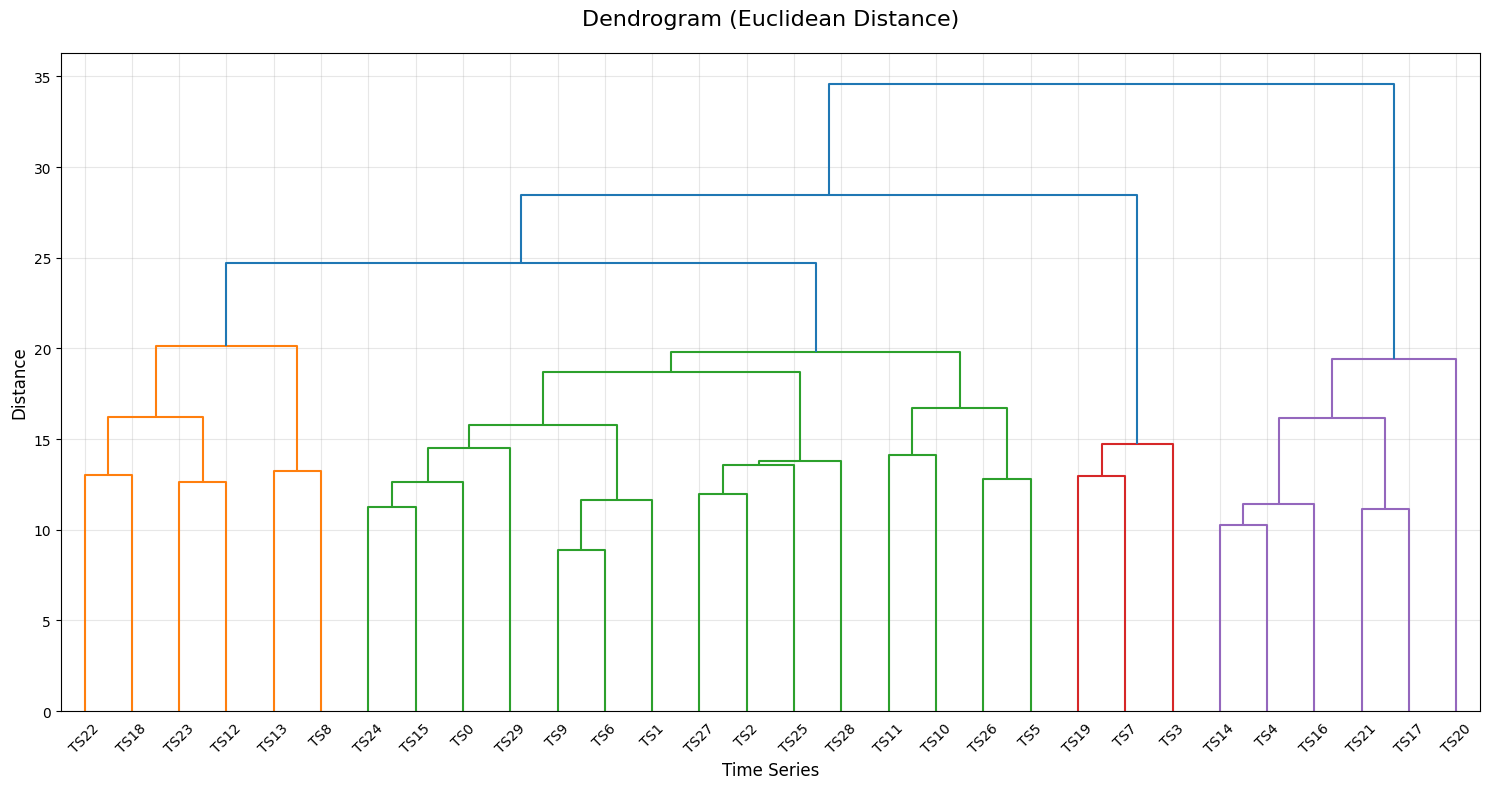


--- DTW Clustering ---
Distance matrix range: [0.0000, 101.7419]
Linkage distances range: [42.1228, 186.5310]


C:\Users\Shaib\AppData\Local\Temp\ipykernel_29048\798110078.py:41: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



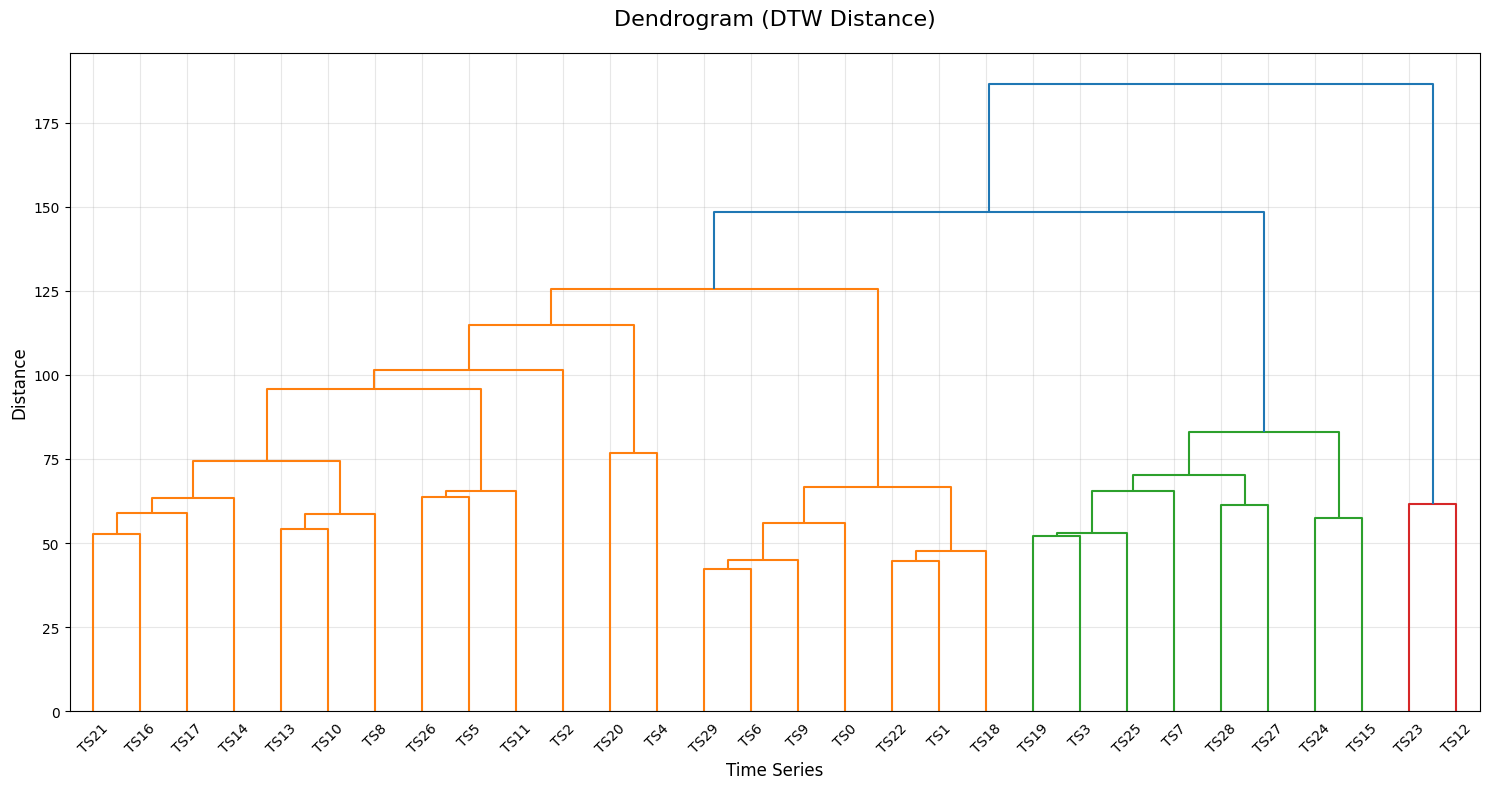


=== CLUSTERING RESULTS ===
True labels: [1 1 1 3 2 2 1 3 2 1 2 2 1 2 2 3 2 2 1 3 2 2 1 1 3 3 2 3 3 1]
Euclidean cluster labels: [0 0 0 2 1 0 0 2 0 0 0 0 0 0 1 0 1 1 0 2 1 1 0 0 0 0 0 0 0 0]
DTW cluster labels: [0 0 0 2 0 0 0 2 0 0 0 0 1 0 0 2 0 0 0 2 0 0 0 1 2 2 0 2 2 0]
Adjusted Rand Index (Euclidean): 0.1369
Adjusted Rand Index (DTW): 0.4863


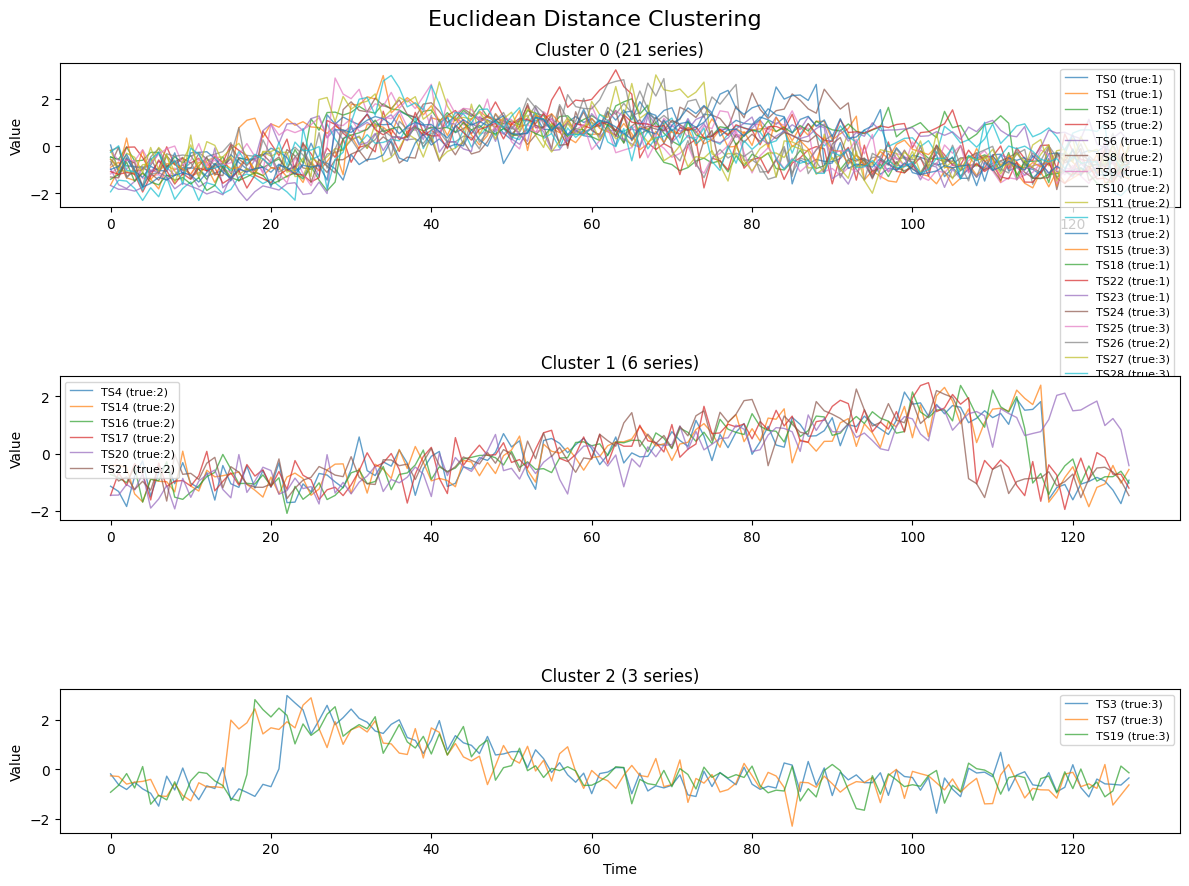

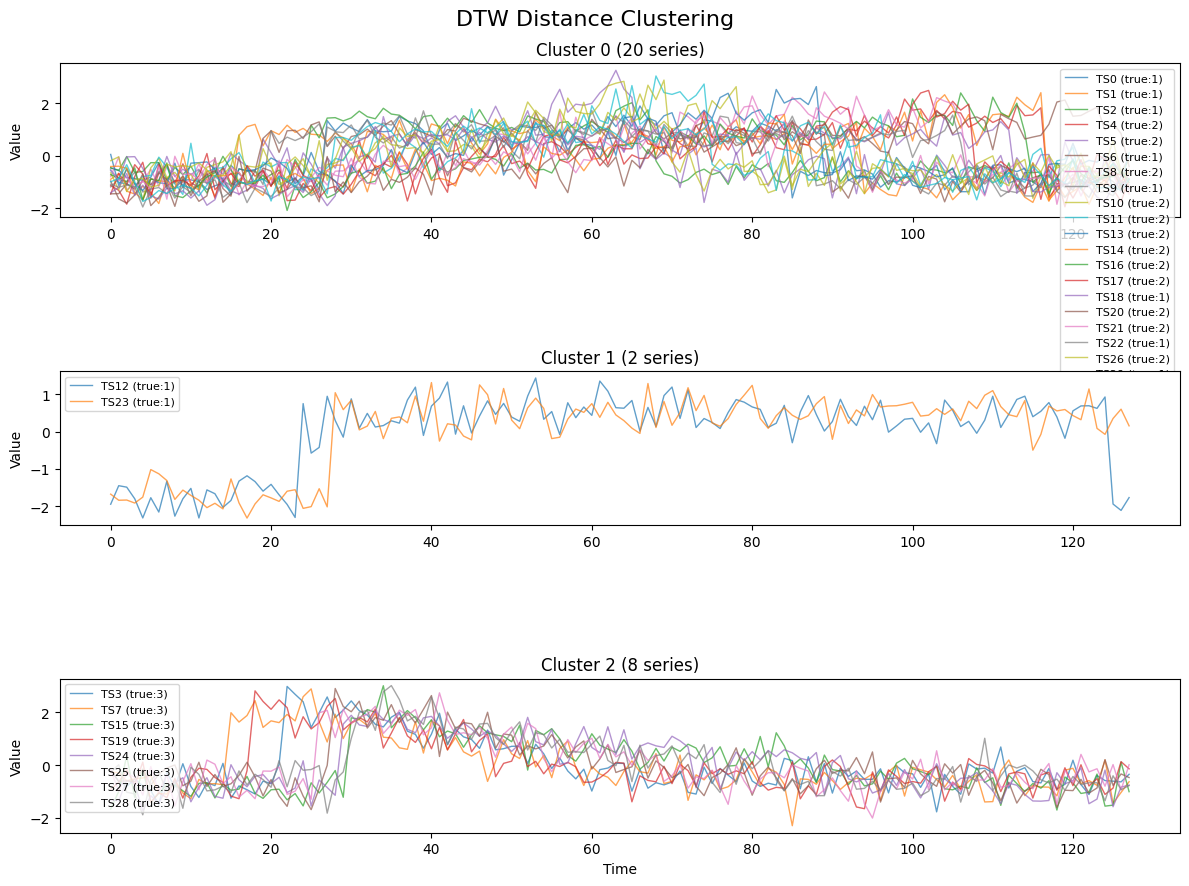

In [119]:
# -----------------------------
# 4️⃣ Вычисляем матрицы расстояний + ДИАГНОСТИКА
# -----------------------------
pairwise_distance_euclidean = PairwiseDistance(metric='euclidean')
dist_matrix_euclidean = pairwise_distance_euclidean.calculate(ts_set)

pairwise_distance_dtw = PairwiseDistance(metric='dtw')
dist_matrix_dtw = pairwise_distance_dtw.calculate(ts_set)

# ДИАГНОСТИКА: посмотрим на матрицы расстояний
print("=== ДИАГНОСТИКА МАТРИЦ РАССТОЯНИЙ ===")
print("Форма матрицы Euclidean:", dist_matrix_euclidean.shape)
print("Min Euclidean:", np.min(dist_matrix_euclidean))
print("Max Euclidean:", np.max(dist_matrix_euclidean))
print("Mean Euclidean:", np.mean(dist_matrix_euclidean))

print("Форма матрицы DTW:", dist_matrix_dtw.shape)
print("Min DTW:", np.min(dist_matrix_dtw))
print("Max DTW:", np.max(dist_matrix_dtw))
print("Mean DTW:", np.mean(dist_matrix_dtw))

# Проверим на NaN и бесконечности
print("NaN в Euclidean:", np.isnan(dist_matrix_euclidean).any())
print("Inf в Euclidean:", np.isinf(dist_matrix_euclidean).any())
print("NaN в DTW:", np.isnan(dist_matrix_dtw).any())
print("Inf в DTW:", np.isinf(dist_matrix_dtw).any())

# -----------------------------
# 5️⃣ ИСПРАВЛЕННАЯ КЛАСТЕРИЗАЦИЯ С ПРАВИЛЬНЫМИ ДАННЫМИ
# -----------------------------
class TimeSeriesHierarchicalClustering:
    def __init__(self):
        self.model = None
        self.linkage_matrix = None

    def fit(self, distance_matrix, n_clusters=3):
        # Проверяем матрицу расстояний
        print(f"Distance matrix range: [{np.min(distance_matrix):.4f}, {np.max(distance_matrix):.4f}]")
        
        # linkage для дендрограммы
        self.linkage_matrix = linkage(distance_matrix, method='average')
        
        print(f"Linkage distances range: [{np.min(self.linkage_matrix[:, 2]):.4f}, {np.max(self.linkage_matrix[:, 2]):.4f}]")
        
        # AgglomerativeClustering для кластеров
        self.model = AgglomerativeClustering(
            n_clusters=n_clusters,
            metric='precomputed',
            linkage='average'
        )
        self.model.fit(distance_matrix)
        return self

    def plot_dendrogram(self, title='Dendrogram'):
        if self.linkage_matrix is None:
            raise ValueError("Сначала вызовите fit()")

        plt.figure(figsize=(15, 8))
        
        # Строим дендрограмму с настройками
        dendrogram(
            self.linkage_matrix,
            orientation='top',
            labels=[f'TS{i}' for i in range(len(self.linkage_matrix)+1)],
            distance_sort='descending',
            show_leaf_counts=True
        )
        
        plt.title(title, fontsize=16, pad=20)
        plt.ylabel('Distance', fontsize=12)
        plt.xlabel('Time Series', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def get_clusters(self):
        """Возвращает метки кластеров"""
        if self.model is not None:
            return self.model.labels_
        return None

# -----------------------------
# 6️⃣ ВЫЧИСЛЯЕМ МАТРИЦЫ РАССТОЯНИЙ ПРАВИЛЬНО
# -----------------------------
from sklearn.metrics.pairwise import euclidean_distances

# Евклидово расстояние
dist_matrix_euclidean = euclidean_distances(ts_set)
print("=== EUCLIDEAN DISTANCE MATRIX ===")
print(f"Shape: {dist_matrix_euclidean.shape}")
print(f"Range: {np.min(dist_matrix_euclidean):.4f} - {np.max(dist_matrix_euclidean):.4f}")
print(f"Mean: {np.mean(dist_matrix_euclidean):.4f}")

# DTW расстояние (упрощенная реализация)
def calculate_dtw_matrix(ts_set):
    """Вычисляет матрицу DTW расстояний"""
    n = ts_set.shape[0]
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            # Простая реализация DTW
            a, b = ts_set[i], ts_set[j]
            n_a, n_b = len(a), len(b)
            dtw_matrix = np.zeros((n_a+1, n_b+1))
            dtw_matrix[0, 1:] = np.inf
            dtw_matrix[1:, 0] = np.inf
            
            for k in range(1, n_a+1):
                for l in range(1, n_b+1):
                    cost = abs(a[k-1] - b[l-1])
                    dtw_matrix[k, l] = cost + min(dtw_matrix[k-1, l],    # вставка
                                                 dtw_matrix[k, l-1],    # удаление
                                                 dtw_matrix[k-1, l-1])  # совпадение
            
            dist = dtw_matrix[n_a, n_b]
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    
    return dist_matrix

# Вычисляем DTW матрицу (может занять время для больших данных)
print("\n=== CALCULATING DTW DISTANCE MATRIX ===")
dist_matrix_dtw = calculate_dtw_matrix(ts_set)
print(f"DTW Matrix Range: {np.min(dist_matrix_dtw):.4f} - {np.max(dist_matrix_dtw):.4f}")
print(f"DTW Matrix Mean: {np.mean(dist_matrix_dtw):.4f}")

# -----------------------------
# 7️⃣ КЛАСТЕРИЗАЦИЯ И ВИЗУАЛИЗАЦИЯ
# -----------------------------

# Определяем оптимальное число кластеров (по количеству уникальных меток)
n_clusters = len(np.unique(labels))
print(f"\n=== CLUSTERING WITH {n_clusters} CLUSTERS ===")

# Евклидова кластеризация
print("\n--- Euclidean Clustering ---")
hierarchical_euclidean = TimeSeriesHierarchicalClustering()
hierarchical_euclidean.fit(dist_matrix_euclidean, n_clusters=n_clusters)
hierarchical_euclidean.plot_dendrogram(title='Dendrogram (Euclidean Distance)')

# DTW кластеризация
print("\n--- DTW Clustering ---")
hierarchical_dtw = TimeSeriesHierarchicalClustering()
hierarchical_dtw.fit(dist_matrix_dtw, n_clusters=n_clusters)
hierarchical_dtw.plot_dendrogram(title='Dendrogram (DTW Distance)')

# -----------------------------
# 8️⃣ АНАЛИЗ РЕЗУЛЬТАТОВ
# -----------------------------

# Получаем метки кластеров
euclidean_labels = hierarchical_euclidean.get_clusters()
dtw_labels = hierarchical_dtw.get_clusters()

print("\n=== CLUSTERING RESULTS ===")
print("True labels:", labels)
print("Euclidean cluster labels:", euclidean_labels)
print("DTW cluster labels:", dtw_labels)

# Сравниваем с истинными метками
from sklearn.metrics import adjusted_rand_score

if euclidean_labels is not None:
    ari_euclidean = adjusted_rand_score(labels, euclidean_labels)
    print(f"Adjusted Rand Index (Euclidean): {ari_euclidean:.4f}")

if dtw_labels is not None:
    ari_dtw = adjusted_rand_score(labels, dtw_labels)
    print(f"Adjusted Rand Index (DTW): {ari_dtw:.4f}")

# -----------------------------
# 9️⃣ ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ
# -----------------------------

def plot_clusters(ts_set, cluster_labels, true_labels, title):
    """Визуализирует временные ряды по кластерам"""
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3*n_clusters))
    if n_clusters == 1:
        axes = [axes]
    
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        for idx in cluster_indices:
            axes[i].plot(ts_set[idx], alpha=0.7, linewidth=1, 
                        label=f'TS{idx} (true:{true_labels[idx]})')
        
        axes[i].set_title(f'Cluster {cluster} ({len(cluster_indices)} series)')
        axes[i].set_ylabel('Value')
        axes[i].legend(fontsize=8)
    
    plt.xlabel('Time')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Визуализируем результаты кластеризации
if euclidean_labels is not None:
    plot_clusters(ts_set, euclidean_labels, labels, 'Euclidean Distance Clustering')

if dtw_labels is not None:
    plot_clusters(ts_set, dtw_labels, labels, 'DTW Distance Clustering')

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [ ]:
# INSERT YOUR CODE

In [129]:
# Сначала проверим, что у нас есть метки
print("Euclidean labels shape:", hierarchical_clustering_euclidean.model.labels_.shape)
print("Unique labels (Euclidean):", np.unique(hierarchical_clustering_euclidean.model.labels_))
print("DTW labels shape:", hierarchical_clustering_dtw.model.labels_.shape)
print("Unique labels (DTW):", np.unique(hierarchical_clustering_dtw.model.labels_))
print("TS_set shape:", ts_set.shape)

Euclidean labels shape: (30,)
Unique labels (Euclidean): [0 1 2]
DTW labels shape: (30,)
Unique labels (DTW): [0 1 2]
TS_set shape: (2, 3000)


In [132]:
# Перезагрузим данные правильно
print("Проверка исходных данных:")
print("Исходные данные shape:", data.shape)
print("Первые 5 строк данных:")
print(data[:5])

# Правильное извлечение временных рядов
ts_set_correct = data[:, 1:]  # все ряды, начиная со второго столбца
labels_correct = data[:, 0].astype(int)  # первый столбец - метки

print("Правильная форма ts_set:", ts_set_correct.shape)
print("Правильная форма labels:", labels_correct.shape)

Проверка исходных данных:
Исходные данные shape: (30, 129)
Первые 5 строк данных:
[[ 1.         -0.46427649 -0.55504787 -0.8428431  -0.86589548 -0.93639631
  -0.81726995 -0.26361216 -1.2580483  -1.2503934  -0.91830825 -0.92210226
  -0.98448828 -1.2880511  -1.14346    -1.0488611  -0.36538582 -0.6913952
  -0.98055025 -0.99133601 -0.88708673 -1.109881   -0.7687248  -1.0102962
  -0.84699606 -1.3277464  -0.7129093  -1.2977275   1.3314643   0.9357379
   1.2360468   1.0560677   0.91074495  1.3713479   0.93705876  0.91029198
   0.93108664  1.4937796   1.3192656   1.2190887   0.94836262  0.16902251
   0.97739879  1.2301476   0.57156683  0.75134091  0.96185121  0.7813122
   1.1044295   1.0003177   0.5507251   0.2688748   1.1255209   1.0758635
   1.071738    1.1544819   0.75940186  0.1511864   1.0202768   1.2572739
   1.007149    1.1624171   0.82999734  1.4850935   1.1050903   1.5393173
   1.1156157   1.8913625   1.3900586   1.1566925   1.5148579   1.6335918
   0.8102606   0.67666423  0.7093935  

In [133]:
from sklearn.metrics import silhouette_score

# Просто используем матрицы расстояний вместо ts_set
sil_euclidean = silhouette_score(dist_matrix_euclidean, euclidean_labels, metric='precomputed')
sil_dtw = silhouette_score(dist_matrix_dtw, dtw_labels, metric='precomputed')

print(f"Euclidean: {sil_euclidean:.4f}, DTW: {sil_dtw:.4f}")

Euclidean: -0.1792, DTW: -0.2041


In [134]:
from sklearn.metrics import silhouette_score

# Способ 1: Используем предвычисленные матрицы расстояний (правильный способ)
sil_euclidean = silhouette_score(
    dist_matrix_euclidean, 
    hierarchical_clustering_euclidean.model.labels_,
    metric='precomputed'
)

sil_dtw = silhouette_score(
    dist_matrix_dtw,
    hierarchical_clustering_dtw.model.labels_,
    metric='precomputed'
)

print(f"Silhouette Score (Euclidean): {sil_euclidean:.4f}")
print(f"Silhouette Score (DTW): {sil_dtw:.4f}")

# Сравниваем результаты
if sil_euclidean > sil_dtw:
    print("Евклидово расстояние дает лучшую кластеризацию")
elif sil_euclidean < sil_dtw:
    print("DTW расстояние дает лучшую кластеризацию")
else:
    print("Оба метода дают одинаковое качество")

ValueError: Found input variables with inconsistent numbers of samples: [30, 2]

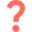
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [ ]:
# INSERT YOUR CODE

### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [120]:
url1 = './datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = read_ts(url2)

C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

C:\Users\Shaib\Documents\GitHub\2025Shaibel\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [121]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [122]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [123]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [124]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

In [ ]:
# INSERT YOUR CODE

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [ ]:
# INSERT YOUR CODE

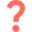
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

*# WRITE YOUR ANSWER*

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [ ]:
# INSERT YOUR CODE

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [ ]:
angle_step = 20
visualize = True

ts = image2ts(img, angle_step, visualize)
plot_ts(np.array([ts]), "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [ ]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [ ]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

In [ ]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [ ]:
# INSERT YOUR CODE

Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [ ]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# INSERT YOUR CODE

In [ ]:
metric = 'dtw'
metric_params = {'normalize': True}

# INSERT YOUR CODE

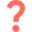
Проанализируйте результаты и сделайте выводы.

*# WRITE YOUR ANSWER*